# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Post-Calibration
With access to higher-grade instruments, we start to look at the possibility of post-calibrating the sensors to get more-reliable results.

## Package Import

In [3]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report
from src.calibration import run_calibration

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import
In the following cells, we grab the relevant data for the calibration events:
1. Background 2
 - **Start**: datetime(2020,12,28,11,12,0)
 - **End**: datetime(2020,12,28,12,12,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 34, 36, 38, 40, 44, 46, 48]
2. Candle 1
 - **Start**: datetime(2020,12,30,10,20,0)
 - **End**: datetime(2020,12,30,12,25,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
3. Background 3
 - **Start**: datetime(2020,12,30,12,40,0)
 - **End**: datetime(2020,12,31,12,40,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
4. Candle 2
 - **Start**: datetime(2020,12,31,13,0,0)
 - **End**: datetime(2021,1,1,13,0,0)
 - **Beacons**: [1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48]
 

In [40]:
c = run_calibration.Linear_Model(datetime(2020,12,30,12,40,0),datetime(2020,12,31,12,40,0),"../data/")

## Beacons
We have to grab the raw data from the beacons during the various calibration events. We can borrow from the ```process_beacon.py``` from the ```make_dataset.py``` source file.

In [41]:
beacon = c.get_beacon_data([1, 4, 5, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 40, 44, 46, 48])

## Reference Instruments
All data are saved as dataframes in a dictionary indexed by the pollutant type

In [42]:
ref = {}
for pollutant, f in zip(["pm_number","pm_concentration","no","no2","co2"],[c.get_pm_ref,c.get_pm_ref,c.get_no_ref,c.get_no2_ref,c.get_co2_ref]):
    print("reading for", pollutant)
    ref[pollutant] = f(f"{pollutant}_{c.date}.csv")

reading for pm_number
reading for pm_concentration
reading for no
reading for no2
reading for co2


# Base Visualization
Visually comparing measurements

## Inspection of Reference Measurements

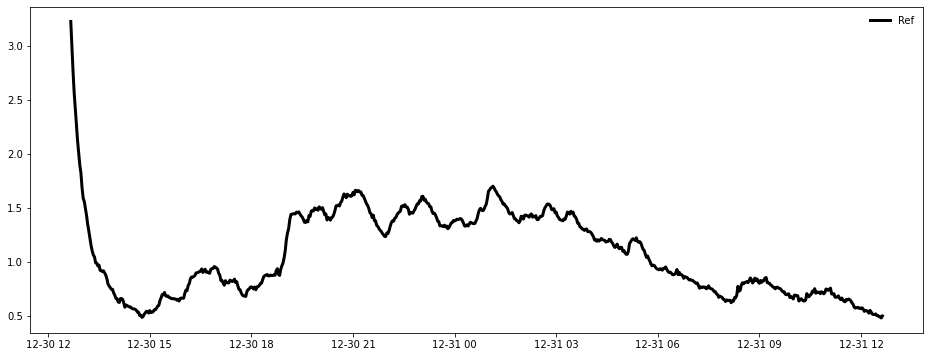

In [43]:
#c.inspect(ref["pm_concentration"][["PM_2p5"]])
c.inspect(ref["no2"])
#c.inspect(beacon[["PM_N_2p5","Beacon"]],timeseries=False)

## Inspection of Beacon Measurements

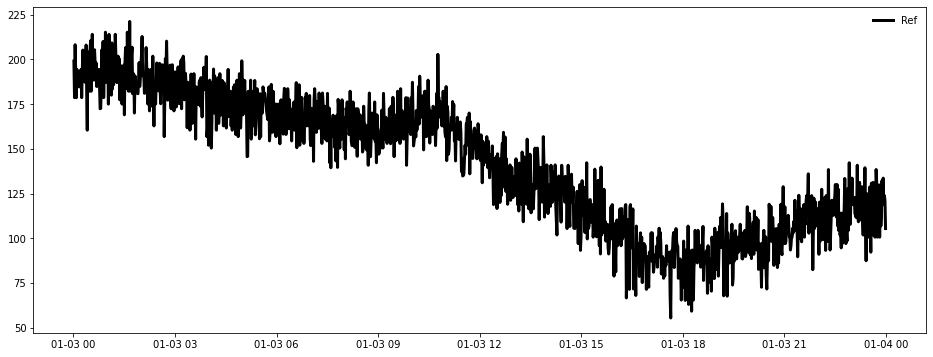

In [44]:
df = pd.read_csv("../data/raw/bpeace2/beacon/B24/adafruit/b24_2021-01-03.csv",index_col=0,parse_dates=True)
c.inspect(df[["NO2"]])

## Comparisons Between Beacons and Reference

In [ ]:
c.compare_time_series(ref["co2"],beacon[["CO2","Beacon"]])

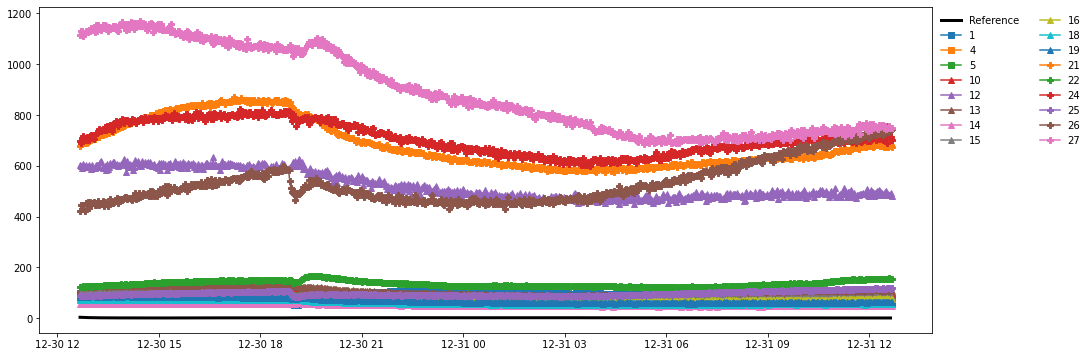

In [45]:
c.compare_time_series(ref["no2"],beacon[["NO2","Beacon"]])

In [ ]:
c.compare_time_series(ref["no"],beacon[["NO2","Beacon"]])

In [ ]:
c.compare_time_series(ref["pm_concentration"][["PM_2p5"]],beacon[["PM_C_2p5","Beacon"]])

# Analysis
In this section, we take a look at correcting the low-cost sensors to the reference machines in three ways:
1. Constant/Offset
2. Linear Regression
3. Random Forest

The following sections are first broken down by pollutant and then by method.

## NO2
NO2 is measured on the Beacon by the [SPEC DGS NO2](https://www.spec-sensors.com/wp-content/uploads/2017/01/DGS-NO2-968-043_9-6-17.pdf) sensor

In [32]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Linear Regression
We can run linear regression for each of the beacons to determine how we can best correct our data.

In [47]:
df = beacon[beacon["Beacon"] == 32]
df_ref = ref["no2"]
m = c.regression(df_ref[["Concentration"]],df[["NO2"]])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').